## CTR  (click through rate) 

#### 1.1 FM
- Only consider the USER and ITEM  
- sparse matrix will in well precision

#### 1.2 MF

#### 1.3 GBDT+LR
###### 1.3.1 conditions: 
    - large amount of sampling in prediction
    - learning capability is low
    - hand-selective features 
    - EDA lacking loss fitting

###### 1.3.2 Stacking: 
- [Paper: predicting-clicks-facebook](https://research.fb.com/wp-content/uploads/2016/11/practical-lessons-from-predicting-clicks-on-ads-at-facebook.pdf)
<img style="float: right;" src="fb-predict-click.png" width="40%">

- Both GBDT and logistic regression are well-known classification models. GBDT-LR algorithm combines these two models by taking the index of the prediction leaf node for every tree as the sparse input for the linear classifier, logistic regression. GBDT first trains the original training data to obtain a binary classifier. Of course, grid search is also needed to find the best parameter combination. Unlike the usual practice, when GBDT is trained to make predictions, the output is not the final binary probability value, but the leaf node position to which the predicted probability value of each tree in the model belongs. Is 1, in this way, new training data is constructed.


- x is an input sample. After traversing two trees, the x samples fall on the leaf nodes of the two trees. Each leaf node corresponds to the LR one-dimensional feature. Then, by traversing the tree, you get All LR features corresponding to this sample. The new feature vector constructed is a value of 0/1. For example: the above picture has two trees, the left tree has three leaf nodes, the right tree has two leaf nodes, and the final feature is a five-dimensional vector. For input x, suppose that he falls in the first node of the left tree, encoding [1,0,0], and the second node in the right tree encodes [0,1], so the overall encoding is [1,0, 0,0,1], this type of coding is used as a feature and is input into the LR for classification.


- After the new training data is constructed, the next step is to input the label (output) data in the original training data into the Logistic Regression classifier to train the final classifier. Think about it, after the operation of extracting GBDT from the original data into new data, the data not only becomes sparse, but also due to the number of weak classifiers and the number of leaf nodes, it may lead to new training data feature dimensions The problem is too large. Therefore, in the Logistic Regression layer, regularization can be used to reduce the risk of over-fitting. In the Facebook paper, L1 regularization is used.


In [1]:
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
#model generation
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

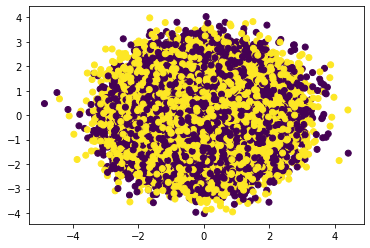

In [11]:
#model generation
n_estimator = 10
X, y = make_classification(n_samples=80000, n_features=20)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

/home/guanqzha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/guanqzha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


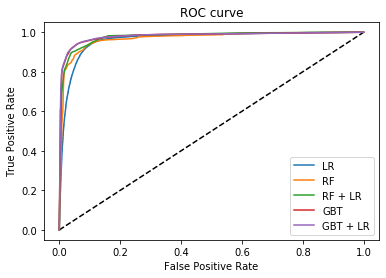

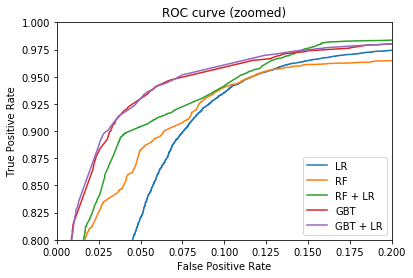

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf.fit(X_train, y_train)
rf_enc = OneHotEncoder(categories='auto')
rf_enc.fit(rf.apply(X_train))


#LR
rf_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

#GBDT
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd.fit(X_train, y_train)

grd_enc = OneHotEncoder(categories='auto')

#temp = grd.apply(X_train)
np.set_printoptions(threshold=np.inf)  
grd_enc.fit(grd.apply(X_train)[:, :, 0])

grd_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)
#prediction
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

# GBDT
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

# RF
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_skl = roc_curve(y_test, y_pred_rf)

#LR
LR = LogisticRegression(n_jobs=4, C=0.1, penalty='l2')
LR.fit(X_train, y_train)
y_pred = LR.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)
 

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (zoomed)')
plt.legend(loc='best')
plt.show()


##### 1.4 DeepCTR
- [Paper: Wide & Deep Learning for Recommender Systems](https://arxiv.org/pdf/1606.07792.pdf)
- The concept is to join the two methods of memorizing and generalizing the learnings by making a wide linear model and a deep learning model respectively together called Wide and Deep Learning. Do check out the previous tutorials on Linear Models for a better understanding of this tutorial.
![wide&deep](wide&deep.png)



In [20]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr.models import WDL
# from deepctr.inputs import SparseFeat,get_feature_names
from deepctr.feature_column import SparseFeat,get_feature_names

data = pd.read_csv("movielens_sample.txt")
sparse_features = ["movie_id", "user_id", "gender", "age", "occupation", "zip"]
target = ['rating']

 
for feature in sparse_features:
    lbe = LabelEncoder()
    data[feature] = lbe.fit_transform(data[feature])
 

fixlen_feature_columns = [SparseFeat(feature, data[feature].nunique()) for feature in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
 
train, test = train_test_split(data, test_size=0.2)
train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}
 
model = WDL(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(train_model_input, train[target].values, batch_size=256, epochs=1, verbose=True, validation_split=0.2, )
#  WDL 
pred_ans = model.predict(test_model_input, batch_size=256)
#  RMSE MSE
mse = round(mean_squared_error(test[target].values, pred_ans), 4)
rmse = mse ** 0.5
print("test RMSE", rmse)
print("test mse", mse)


Train on 128 samples, validate on 32 samples


/home/guanqzha/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/guanqzha/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


128/128 [==============================] - 2s 12ms/sample - loss: 13.3826 - mse: 13.3826 - val_loss: 15.2613 - val_mse: 15.2613
test RMSE 3.931691747835784
test mse 15.4582


###### 1.5 NFM 

- [paper: Neural Factorization Machines for Sparse Predictive Analyticsâˆ—](https://arxiv.org/pdf/1708.05027.pdf)
<img style="float: right;" src="NFM.png" width="40%">
- NFM seamlessly combines the linearity of FM in modelling second-order feature interactions and the non-linearity of neural network in modelling higher-order feature interactions. Conceptually, NFM is more expressive than FM since FM can be seen as a special case of NFM without hidden layers. Empirical results on two regression tasks show that with one hidden layer only, NFM significantly outperforms FM with a 7.3% relative improvement. Compared to the recent deep learning methods Wide&Deep and DeepCross, our NFM uses a shallower structure but offers better performance, being much easier to train and tune in practice.

In [16]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr.models import NFM
# from deepctr.inputs import SparseFeat,get_feature_names
from deepctr.feature_column import SparseFeat,get_feature_names

In [17]:

data = pd.read_csv("movielens_sample.txt")
sparse_features = ["movie_id", "user_id", "gender", "age", "occupation", "zip"]
target = ['rating']
 
for feature in sparse_features:
    lbe = LabelEncoder()
    data[feature] = lbe.fit_transform(data[feature])
    
    
fixlen_feature_columns = [SparseFeat(feature, data[feature].nunique()) for feature in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

 
train, test = train_test_split(data, test_size=0.2)
train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

 
model = NFM(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(train_model_input, train[target].values, batch_size=256, epochs=1, verbose=True, validation_split=0.2, )
 
pred_ans = model.predict(test_model_input, batch_size=256)
# RMSE&&MSE
mse = round(mean_squared_error(test[target].values, pred_ans), 4)
rmse = mse ** 0.5
print("test RMSE", rmse)
print("test mse", mse)

Train on 128 samples, validate on 32 samples


/home/guanqzha/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/guanqzha/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


128/128 [==============================] - 2s 17ms/sample - loss: 14.1250 - mse: 14.1250 - val_loss: 15.4264 - val_mse: 15.4264
test RMSE 3.6027767069303644
test mse 12.98


##### 1.6 Prediction buying preferrence
- to be continued